# Abstract

In this blog post, I will be implementing and explaining my entry into the Kaggle competition titled *Titanic - Machine Learning from Disaster*. First, I will explore the Titanic survival dataset supplied by the competition and hopefully come up with an effective strategy to approach the problem. Then, I will compare a few classification models and determine which one I should use in my entry. Finally, I will tune the best model, and possibly further experiment to maximize its prediction accuracy.

# Data Exploration

In [40]:
import pandas as pd

df = pd.read_csv('train.csv')

Here I load the data and get a quick look at it to analyze the features.

In [41]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

I don't think that most of these features will be relevant in predicting whether a passenger survived or not. Some will even be unusable as input to a classification model due to their values being unique (e.g., each ticket has their own number, which would create an enormous input vector if I were to one-hot encode it). Therefore, I drop the rows outside of `Survived`, `Pclass`, `Sex`, `Age`, and `Fare`.

In [43]:
df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], axis= 1, inplace= True)

Looking at the data types, I will have to one-hot encode the `Sex` feature in order to use it as input.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   Fare      891 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 34.9+ KB


In [45]:
df = pd.get_dummies(df)
df.head()

,Survived,Pclass,Age,Fare,Sex_female,Sex_male
0,0,3,22.0,7.2500,False,True
1,1,1,38.0,71.2833,True,False
2,1,3,26.0,7.9250,True,False
3,1,1,35.0,53.1000,True,False
4,0,3,35.0,8.0500,False,True


Looking at distributions of passengers within ticket classes, most of the passengers rode in the 3rd class and the least amount of passengers, by very few, rode in 2nd class.

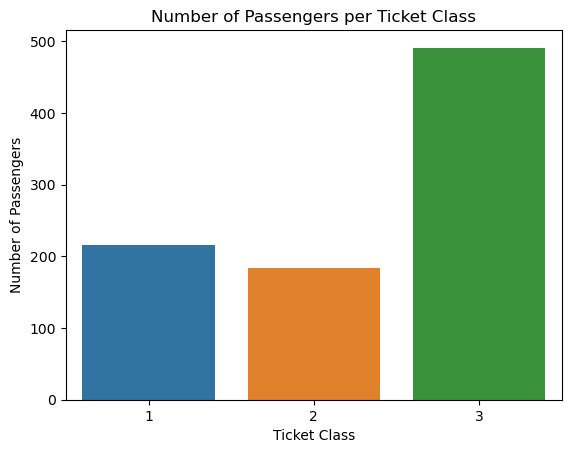

In [46]:
plot1 = sns.countplot(data= df, x= 'Pclass')
plot1.set(xlabel= 'Ticket Class', ylabel= 'Number of Passengers', title= 'Number of Passengers per Ticket Class')
plt.show() 

Then, I calculate and graph the survival rates for each ticket class. As somewhat expected, there is a correlation between survivability and the ranking of the ticket classes, i.e., 1st class had the highest survival rate, followed by 2nd class, then 3rd class.

In [47]:
class1 = df[df['Pclass'] == 1]
class2 = df[df['Pclass'] == 2]
class3 = df[df['Pclass'] == 3]

sr_c1 = class1['Survived'].aggregate('mean')
sr_c2 = class2['Survived'].aggregate('mean')
sr_c3 = class3['Survived'].aggregate('mean')

print(f'The survival rate for ticket class 1 was {sr_c1*100:.2f}%')
print(f'The survival rate for ticket class 2 was {sr_c2*100:.2f}%')
print(f'The survival rate for ticket class 3 was {sr_c3*100:.2f}%')

The survival rate for ticket class 1 was 62.96%
The survival rate for ticket class 2 was 47.28%
The survival rate for ticket class 3 was 24.24%


c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


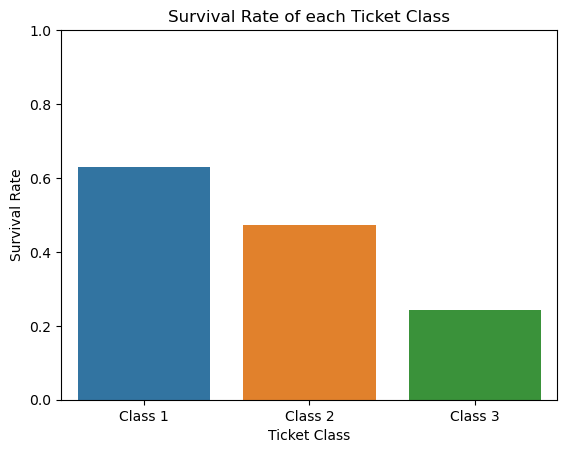

In [48]:
plot2 = sns.barplot(x= ['Class 1', 'Class 2', 'Class 3'], y= [sr_c1, sr_c2, sr_c3])
plot2.set(xlabel= 'Ticket Class', ylabel= 'Survival Rate', ylim= (0.0, 1.0), title= 'Survival Rate of each Ticket Class')
plt.show()

I then graph the age distribution across all passengers. It seems that most of the passengers fall between the 20-40 age range.

c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


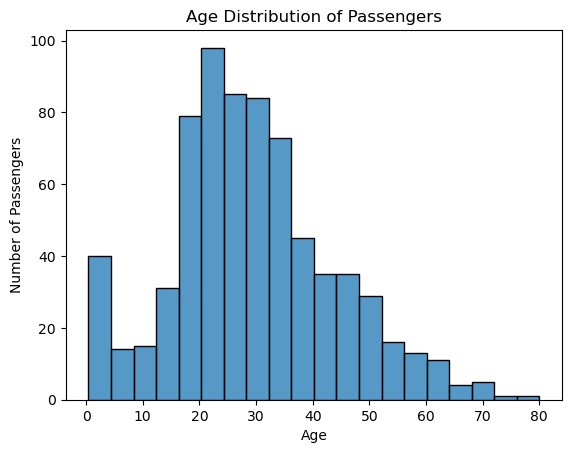

In [49]:
plot3 = sns.histplot(data= df, x= 'Age')
plot3.set(ylabel= 'Number of Passengers', title= 'Age Distribution of Passengers')
plt.show()

I then create a heatmap of the feature correlation in my dataset. I am looking mainly at features that have a positive correlation with my independent variable (the one to be predicted), `Survived`. It seems that a passenger being a female has a large correlation with survivability, as well as the fare that someone paid for their ticket.

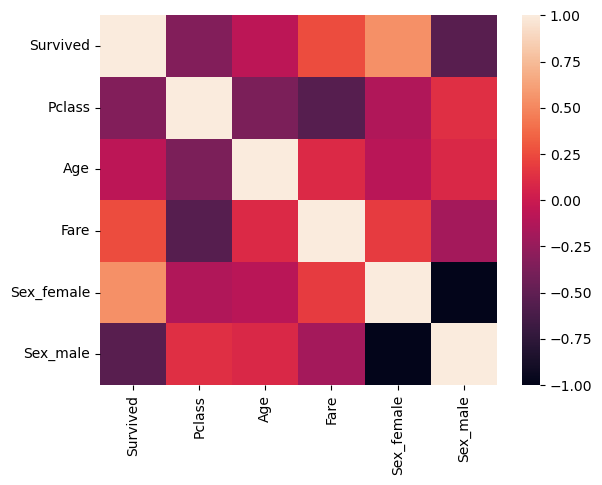

In [50]:
plot4 = sns.heatmap(df.corr())

Referring back to the `df.info()` call, there seems to be many empty values in the `Age` category. To deal with this, I take two approaches, one simply takes out all of the empty values, and the other replaces the missing values with the mean value of the `Age` category.

In [51]:
df_noNaN = df.copy().dropna()

df_mean = df.copy()
df_mean['Age'].fillna(df_mean['Age'].mean(), inplace= True)

print(df_noNaN.shape)
print(df_mean.shape)

(714, 6)
(891, 6)


Here I create preprocessing methods for ease of use later; I make one for each method of dealing with the missing `Age` values.

In [86]:
def preprocess_noNaN(df):
    df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], axis= 1, inplace= True)
    df = pd.get_dummies(df)
    df = df.dropna(axis= 0)

    y = [0]*len(df)
    if 'Survived' in df:
        y = df['Survived']
        df.drop(['Survived'], axis= 1, inplace= True)

    return df, y

def preprocess_mean(df):
    y = [0]*len(df)
    if 'Survived' in df:
        y = df['Survived']
        df.drop(['Survived'], axis= 1, inplace= True)

    df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], axis= 1, inplace= True)
    df = pd.get_dummies(df)
    df['Age'].fillna(df['Age'].mean(), inplace= True)
    return df, y

# Building Models

Here I will be implementing three different classification models from the `scikit-learn` library: a logistic regression model, a decision tree classifier, and a support vector machine.

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

I then split the data into training and testing sets, and preprocess each split using my premade methods so that they can be used as input for the classification models. I create two training/testing splits using the two different approaches for dealing with the missing `Age` values.

In [54]:
df = pd.read_csv('train.csv')

train = df.sample(frac=0.75, random_state=100)
test = df.drop(train.index)

X_train_noNaN, y_train_noNaN = preprocess_noNaN(train.copy())
X_train_mean, y_train_mean = preprocess_mean(train.copy())

X_test_noNaN, y_test_noNaN = preprocess_noNaN(test.copy())
X_test_mean, y_test_mean = preprocess_mean(test.copy())

## Logistic Regression Classifier

I will now implement two logistic regression models, each trained on one of the training/test splits, i.e., one model is trained on the split that has removed all missing `Age` values, and the other is trained on the split that has replaced the missing values with the mean `Age` value. I then fit the models on the training data, analyzed their classification accuracy on the training split, made predictions upon the testing split, and produced a classification report so that I can compare this model's accuracy against the others'.

In [55]:
LR_noNaN = LogisticRegression()
LR_mean = LogisticRegression()

LR_noNaN.fit(X_train_noNaN, y_train_noNaN)
LR_mean.fit(X_train_mean, y_train_mean)

LogisticRegression()

In [56]:
print(f'Accuracy of logistic regression after removing missing values on the training data: {LR_noNaN.score(X_train_noNaN, y_train_noNaN)*100:.2f}%')
print(f'Accuracy of logistic regression after replacing missing values with the mean value on the training data: {LR_mean.score(X_train_mean, y_train_mean)*100:.2f}%')

Accuracy of logistic regression after removing missing values on the training data: 81.15%
Accuracy of logistic regression after replacing missing values with the mean value on the training data: 79.49%


In [57]:
LR_preds_noNaN = LR_noNaN.predict(X_test_noNaN)
LR_preds_mean = LR_mean.predict(X_test_mean)

In [58]:
from sklearn.metrics import accuracy_score, classification_report

print('Using testing data:')
print('Classification report for logistic regression without NaN values:')
print(classification_report(y_true= y_test_noNaN, y_pred= LR_preds_noNaN))

print('Classification report for logistic regression with mean age values:')
print(classification_report(y_true= y_test_mean, y_pred= LR_preds_mean))

LR_acc_noNaN = accuracy_score(y_true= y_test_noNaN, y_pred= LR_preds_noNaN)
LR_acc_mean = accuracy_score(y_true= y_test_mean, y_pred= LR_preds_mean)

print(f'The accuracy of the logistic regression model after taking out the NaN age values: {LR_acc_noNaN*100:.2f}%')
print(f'The accuracy of the logistic regression model using mean replacement for age values: {LR_acc_mean*100:.2f}%')

Using testing data:
Classification report for logistic regression without NaN values:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       105
           1       0.74      0.76      0.75        68

    accuracy                           0.80       173
   macro avg       0.79      0.80      0.80       173
weighted avg       0.80      0.80      0.80       173

Classification report for logistic regression with mean age values:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       141
           1       0.66      0.74      0.70        82

    accuracy                           0.77       223
   macro avg       0.75      0.76      0.75       223
weighted avg       0.77      0.77      0.77       223

The accuracy of the logistic regression model after taking out the NaN age values: 80.35%
The accuracy of the logistic regression model using mean replacement for age values: 76.68%


This seems like a fairly accurate, and fairly consistent model. The accuracy of the classifier don't fluctuate too much between the training and testing splits, and it performs to around a 77-80% accuracy on the unseen testing split.

## Decision Tree Classifier
Now, I implement the Decision Tree Classifier from the `scikit-learn` library, and follow the same steps as with the logistic regression model.

In [59]:
DT_noNaN = DecisionTreeClassifier()
DT_mean = DecisionTreeClassifier()

DT_noNaN.fit(X_train_noNaN, y_train_noNaN)
DT_mean.fit(X_train_mean, y_train_mean)

DecisionTreeClassifier()

In [60]:
print(f'Accuracy of decision tree classification after removing missing values on the training data: {DT_noNaN.score(X_train_noNaN, y_train_noNaN)*100:.2f}%')
print(f'Accuracy of decision tree classification after replacing missing values with the mean value on the training data: {DT_mean.score(X_train_mean, y_train_mean)*100:.2f}%')

Accuracy of decision tree classification after removing missing values on the training data: 99.08%
Accuracy of decision tree classification after replacing missing values with the mean value on the training data: 98.80%


In [61]:
DT_preds_noNaN = DT_noNaN.predict(X_test_noNaN)
DT_preds_mean = DT_mean.predict(X_test_mean)

In [62]:
print('Using testing data:')
print('Classification report for decision tree without NaN values:')
print(classification_report(y_true= y_test_noNaN, y_pred= DT_preds_noNaN))

print('Classification report for decision tree with mean age values:')
print(classification_report(y_true= y_test_mean, y_pred= DT_preds_mean))

DT_acc_noNaN = accuracy_score(y_true= y_test_noNaN, y_pred= DT_preds_noNaN)
DT_acc_mean = accuracy_score(y_true= y_test_mean, y_pred= DT_preds_mean)

print(f'The accuracy of the decision tree model after taking out the NaN age values: {DT_acc_noNaN*100:.2f}%')
print(f'The accuracy of the decision tree model using mean replacement for age values: {DT_acc_mean*100:.2f}%')

Using testing data:
Classification report for decision tree without NaN values:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       105
           1       0.67      0.69      0.68        68

    accuracy                           0.75       173
   macro avg       0.73      0.74      0.73       173
weighted avg       0.75      0.75      0.75       173

Classification report for decision tree with mean age values:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       141
           1       0.59      0.70      0.64        82

    accuracy                           0.71       223
   macro avg       0.69      0.71      0.70       223
weighted avg       0.72      0.71      0.71       223

The accuracy of the decision tree model after taking out the NaN age values: 74.57%
The accuracy of the decision tree model using mean replacement for age values: 70.85%


While the accuracy of the Decision Tree classifier on the testing split is not terrible, it is a little worrying how high the accuracy of its performance on the training split is. This leads me to believe that given the relatively few features available for this model, the classifier is likely to overfit to the training data.

## Support Vector Machine Classifier

I repeat the methodology of the Logistic Regression and Decision Tree classifiers with the Support Vector Machine model.

In [63]:
SVM_noNaN = SVC()
SVM_mean = SVC()

SVM_noNaN.fit(X_train_noNaN, y_train_noNaN)
SVM_mean.fit(X_train_mean, y_train_mean)

SVC()

In [64]:
print(f'Accuracy of the SVM after removing missing values on the training data: {SVM_noNaN.score(X_train_noNaN, y_train_noNaN)*100:.2f}%')
print(f'Accuracy of the SVM after replacing missing values with the mean value on the training data: {SVM_mean.score(X_train_mean, y_train_mean)*100:.2f}%')

Accuracy of the SVM after removing missing values on the training data: 67.84%
Accuracy of the SVM after replacing missing values with the mean value on the training data: 68.86%


In [65]:
SVM_preds_noNaN = SVM_noNaN.predict(X_test_noNaN)
SVM_preds_mean = SVM_mean.predict(X_test_mean)

In [66]:
print('Using testing data:')
print('Classification report for SVM without NaN values:')
print(classification_report(y_true= y_test_noNaN, y_pred= SVM_preds_noNaN))

print('Classification report for SVM with mean age values:')
print(classification_report(y_true= y_test_mean, y_pred= SVM_preds_mean))

SVM_acc_noNaN = accuracy_score(y_true= y_test_noNaN, y_pred= SVM_preds_noNaN)
SVM_acc_mean = accuracy_score(y_true= y_test_mean, y_pred= SVM_preds_mean)

print(f'The accuracy of the SVM model after taking out the NaN age values: {SVM_acc_noNaN*100:.2f}%')
print(f'The accuracy of the SVM model using mean replacement for age values: {SVM_acc_mean*100:.2f}%')

Using testing data:
Classification report for SVM without NaN values:
              precision    recall  f1-score   support

           0       0.66      0.83      0.74       105
           1       0.57      0.35      0.44        68

    accuracy                           0.64       173
   macro avg       0.62      0.59      0.59       173
weighted avg       0.63      0.64      0.62       173

Classification report for SVM with mean age values:
              precision    recall  f1-score   support

           0       0.68      0.85      0.76       141
           1       0.55      0.32      0.40        82

    accuracy                           0.65       223
   macro avg       0.62      0.58      0.58       223
weighted avg       0.63      0.65      0.63       223

The accuracy of the SVM model after taking out the NaN age values: 64.16%
The accuracy of the SVM model using mean replacement for age values: 65.47%


While consistent across the training and testing splits, the accuracy of the model is far lower than the Logistic Regression and Decision Tree classifiers. Therefore, I will likely not use this model for my entry. Additionally, due to the Decision Tree model's vulnerability to overfitting, I will likely utilize logistic regression in my final classifier.

## Logistic Regression Tuning

In order to finalize my model, I would first like to find the optimal hyperparameters for the Logistic Regression classifier. To do this, I will create dictionaries containing a range of possible hyperparameters, and run a cross-validated grid search (using the `GridSearchCV` class from the `scikit-learn` library), to find the optimal set. Once I find the optimal hyperparameters for each Logistic Regression model, I will fit them to the training split, and then analyze their accuracies on both the training and unseen testing split. After confirming its effectiveness on the splits I created from the training data file, I will then train finalize whether I want to replace/remove the missing values from the `Age` category.

Note: within the grid search hyperparameter input, I have to make separate dictionaries due to the different solver algorithms. Each solver algorithm only accepts certain types of penalty functions (e.g., the `liblinear` algorithm only works with L1 or L2 penalty functions), so each solver algorithm within the hyperparameter grid is sorted by these penalty functions.

In [72]:
from sklearn.model_selection import GridSearchCV

C_space = np.logspace(start= -100.0, stop= 100.0, num= 100)
m_iter = [100, 500, 1000, 2500]

poss_params = [
  { 'penalty'   : ['l2', None],
    'C'         : C_space,
    'solver'    : ['newton-cg', 'lbfgs'],
    'max_iter'  : m_iter},
    { 'penalty'   : ['l1', 'l2', None],
    'C'         : C_space,
    'solver'    : ['saga'],
    'max_iter'  : m_iter}
]

# this destroys the runtime for some reason
'''{ 'penalty'   : ['l1', 'l2'],
    'C'         : C_space,
    'solver'    : ['liblinear'],
    'max_iter'  : m_iter},
'''

LR = LogisticRegression()
tuner = GridSearchCV(LR, poss_params, cv= 5, verbose= True, n_jobs= 2)

best_LR_noNaN = tuner.fit(X_train_noNaN, y_train_noNaN)
best_LR_mean = tuner.fit(X_train_mean, y_train_mean)


Fitting 5 folds for each of 2800 candidates, totalling 14000 fits


c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Fitting 5 folds for each of 2800 candidates, totalling 14000 fits


c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [73]:
print(f'Accuracy of tuned logistic regression after removing missing values on the training data: {best_LR_noNaN.score(X_train_noNaN, y_train_noNaN)*100:.2f}%')
print(f'Accuracy of tuned logistic regression after replacing missing values with the mean value on the training data: {best_LR_mean.score(X_train_mean, y_train_mean)*100:.2f}%')

Accuracy of tuned logistic regression after removing missing values on the training data: 79.67%
Accuracy of tuned logistic regression after replacing missing values with the mean value on the training data: 79.64%


In [74]:
best_LR_preds_noNaN = best_LR_noNaN.predict(X_test_noNaN)
best_LR_preds_mean = best_LR_mean.predict(X_test_mean)

In [75]:
best_LR_mean.best_estimator_

LogisticRegression(C=1e-100, penalty=None, solver='newton-cg')

In [76]:
print('Using testing data:')
print('Classification report for tuned logistic regression without NaN values:')
print(classification_report(y_true= y_test_noNaN, y_pred= best_LR_preds_noNaN))

print('Classification report for tuned logistic regression with mean age values:')
print(classification_report(y_true= y_test_mean, y_pred= best_LR_preds_mean))

best_LR_acc_noNaN = accuracy_score(y_true= y_test_noNaN, y_pred= best_LR_preds_noNaN)
best_LR_acc_mean = accuracy_score(y_true= y_test_mean, y_pred= best_LR_preds_mean)

print(f'The accuracy of the tuned logistic regression model after taking out the NaN age values: {best_LR_acc_noNaN*100:.2f}%')
print(f'The accuracy of the tuned logistic regression model using mean replacement for age values: {best_LR_acc_mean*100:.2f}%')

Using testing data:
Classification report for tuned logistic regression without NaN values:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       105
           1       0.74      0.74      0.74        68

    accuracy                           0.79       173
   macro avg       0.78      0.78      0.78       173
weighted avg       0.79      0.79      0.79       173

Classification report for tuned logistic regression with mean age values:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       141
           1       0.66      0.74      0.70        82

    accuracy                           0.77       223
   macro avg       0.75      0.76      0.75       223
weighted avg       0.77      0.77      0.77       223

The accuracy of the tuned logistic regression model after taking out the NaN age values: 79.19%
The accuracy of the tuned logistic regression model using mean replacement for age v

It seems that the overall accuracy on the training and testing splits does not really change between the untuned and tuned logistic regression, yet both models are still moderately more accurate than the Decision Tree and SVM classifiers. Now, I will quickly train this 'optimally' tuned logistic regression model on the entire training dataset, predict on the testing dataset, then analyze the overall results, and finally turn in my preliminary entry. If I am not satisfied with how my final entry turns out, I will return and reinvestigate possible other ways to improve my model's accuracy.

# Training and Predicting Preliminary Entry

In this section I am training and tuning a logistic regression model upon the entire training dataset, predicting upon the testing dataset, and then submitted my model's survival predictions to the Kaggle leaderboard.

In [78]:
df_train = pd.read_csv('train.csv')

final_X_train_noNaN, final_y_train_noNaN = preprocess_noNaN(df_train.copy())
final_X_train_mean, final_y_train_mean = preprocess_mean(df_train.copy())

In [79]:
final_LR_noNaN = tuner.fit(final_X_train_noNaN, final_y_train_noNaN)
final_LR_mean = tuner.fit(final_X_train_mean, final_y_train_mean)

Fitting 5 folds for each of 2800 candidates, totalling 14000 fits
Fitting 5 folds for each of 2800 candidates, totalling 14000 fits


In [80]:
print(f'Accuracy of tuned logistic regression after removing missing values on the entire training dataset: {final_LR_noNaN.score(final_X_train_noNaN, final_y_train_noNaN)*100:.2f}%')
print(f'Accuracy of tuned logistic regression after replacing missing values with the mean value on the entire training dataset: {final_LR_mean.score(final_X_train_mean, final_y_train_mean)*100:.2f}%')

Accuracy of tuned logistic regression after removing missing values on the entire training dataset: 79.97%
Accuracy of tuned logistic regression after replacing missing values with the mean value on the entire training dataset: 80.02%


Here we can see that the accuracy for the logistic regression model that replaces the missing values in the `Age` category with the mean `Age` value does marginally well compared to the other approach to handling the missing values. On another note, I have realized that the approach of simply removing data points with missing `Age` values would not be suitable for this task, as the Kaggle leaderboard asks that an entry predicts the survivability of every data point, and therefore, we cannot remove data points, but must make them readable by our model (the `LogisticRegression` model class does not allow for NaN values in a dataset). For these reasons, we will be using the handling approach of replacing missing values with the mean value in their category.

In [106]:
df_test = pd.read_csv('test.csv')

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


After loading and getting a summary of our data, we can see that `Age` and `Fare`, both features that we use in our model, have missing values. Our normal preproccessing functions will handle the missing values in `Age`, but we need to fix the 1 missing `Fare` value. Following the methodology we used for `Age`, we will replace the missing value in `Fare` with the mean value for that category.

In [107]:
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace= True)

Now, we will save the `PassengerIds` so that we can format the submission file to the specs of the Kaggle competition, preprocess the testing dataset, and have our model make predictions upon it.

In [108]:
ids = df_test['PassengerId']

final_X_test, nothing = preprocess_mean(df_test)

survived = final_LR_mean.predict(final_X_test)

Now we will create a dataframe from the list of passenger IDs and survival predictions and then format this dataframe into a .csv file so that we can submit it to the competition.

In [114]:
initial_submission = pd.DataFrame(data= {'PassengerId': ids, 'Survived': survived})
initial_submission.to_csv('initial_submission.csv', index=False)  


My initial approach resulted in a **75.74%** accuracy rate, not bad!

![](titanic_sub_1.png)